## SBER sentiment data parsing and posts filtering

### Module imports

In [1]:
import os, sys, re
from tqdm import tqdm
import sqlite3
import pandas as pd

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import importlib
import scripts.post_parser

importlib.reload(scripts.post_parser)
print('modules reloaded!')

from scripts.post_parser import TinkoffPulseParser

modules reloaded!


In [2]:
current_dir = os.path.dirname(os.path.abspath('__file__'))
project_root = os.path.dirname(current_dir)
database_path = os.path.join(project_root, 'databases', 'sber_posts_2023.db')

### T-Pulse posts parsing

In [2]:
# custom_db = "sber_posts_2023.db"
# parser = TinkoffPulseParser(
#     start_date='2023-01-01',
#     db_name=custom_db
# )
# parser.parse_single_ticker("SBER")

Обрабатывается дата: 2023-01-03T07:48:17.977Z
Получено постов: 178946


2025-03-01 09:41:49,451 - INFO - Достигнута целевая дата 2023-01-01 00:00:00+00:00


### EDA

In [ ]:
conn = sqlite3.connect(database_path)
sber_posts_2023 = pd.read_sql_query("SELECT * FROM tcs_pulse_posts_sber", conn)

In [4]:
sber_posts_2023

,id,post_id,inserted,instruments,hashtags,content,reactions_count,comments_count,parse_dt
0,1,182f9df1-274a-449f-b23b-01ef30f6aac7,2025-02-28T21:56:19.866Z,SBER,None,{$SBER} с такими переговорами скоро Россия и А...,0,0,2025-03-01 00:58:25
1,2,f04df7aa-73dc-4615-91ad-425b6ae2d0d0,2025-02-28T21:43:49.091Z,"SBER, X5, NVTK, YDEX",None,Итоги февраля\nПополнений 0₽\nПосдеднее время ...,0,0,2025-03-01 00:58:25
2,3,2d8173d7-7a65-4401-951f-20a055ab8a06,2025-02-28T21:39:11.933Z,"YDEX, SBER, ROSN, SPBE, AFLT",None,Сам почитываю @krial777_Alexey и @ProfitOffici...,0,0,2025-03-01 00:58:25
3,4,9f4d42b6-2319-4663-ab88-5169d42de15e,2025-02-28T21:35:22.113Z,SBER,"сбер, сбербанк","{$SBER}: Разбираем отчёт Сбербанка - плюсы, ми...",1,0,2025-03-01 00:58:25
4,5,a23081b3-6568-441c-b679-7a67de67ee71,2025-02-28T21:34:52.295Z,SBER,None,{$SBER} .🤣🤣,6,1,2025-03-01 00:58:25
...,...,...,...,...,...,...,...,...,...
178973,178974,5428dcc1-abcd-43f8-9e70-ac3680a281ff,2023-01-01T10:11:45.587Z,"CHMF, SBER, PLZL",интересное,ТОП лидеров падения за 2022 год \n\n#Интересно...,5,1,2025-03-01 09:41:43
178974,178975,2f714a03-0626-4578-985c-991fe1bf92cf,2023-01-01T10:00:30.714Z,"CHMF, NLMK, MAGN, SBER",None,"{$SiH3} Н закрылась так, будто собирается сове...",5,1,2025-03-01 09:41:43
178975,178976,612e098c-3056-4ff1-9081-5e15c2ef321f,2023-01-01T08:49:26.037Z,"GAZP, MOEX, NLMK, SBER, LKOH",None,С Новым годом!\n\nГотовлю к запуску стратегию ...,13,12,2025-03-01 09:41:43
178976,178977,cac4d6e9-97be-40af-910c-6fbd8b98e084,2023-01-01T08:49:00.354Z,"T, SBER, LKOH",None,Братва с НОВЫМ ГОДОМ Желаю иксов за этот год ...,17,0,2025-03-01 09:41:43


Преобразуем дату и посмотрим на динамику публикаций

In [ ]:
sber_posts_2023["inserted"] = pd.to_datetime(sber_posts_2023["inserted"].str[:10])
daily_counts_sber = sber_posts_2023.groupby("inserted").size().reset_index(name="count")

In [6]:
%load_ext autoreload
%autoreload 2
from scripts.vizualizer import plot_daily_posts

plot_daily_posts(daily_counts_sber, "SBER")

Сохраним общее число публикаций на каждый день будем использовать как дополнительный признак в модели:

In [ ]:
sber_posts_2023["total_day_posts_cnt"] = sber_posts_2023.groupby(by="inserted")[
    "id"
].transform("count")

Также нам важно понимать распределение длин текстов:

In [ ]:
sber_posts_2023['words_cnt'] = sber_posts_2023['content'].apply(lambda x: len(x.split()))
sber_posts_2023['post_len'] = sber_posts_2023['content'].apply(len)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


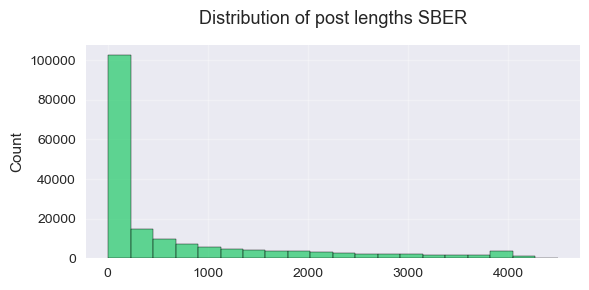

In [10]:
%load_ext autoreload
%autoreload 2
from scripts.vizualizer import plot_posts_length

plot_posts_length(sber_posts_2023, 'SBER', 'post_len', '')

### Content processing

#### Base approach | deleting URLs & HTML tags

In [ ]:
def preprocess_text_base(text):
    # Базовая предобработка
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Удаление URLs
    text = re.sub(r'<.*?>', '', text)  # Удаление HTML тегов
    text = re.sub(r'#\w+', '', text)  # Удаление хэштегов

    return text.strip()

In [12]:
tqdm.pandas()
sber_posts_2023['content_base'] = sber_posts_2023['content'].progress_apply(preprocess_text_base)

100%|██████████| 178978/178978 [00:01<00:00, 120694.71it/s]


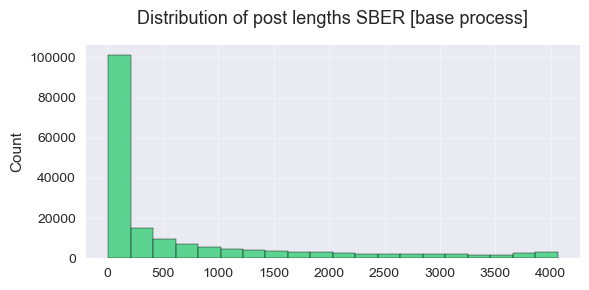

In [ ]:
sber_posts_2023["post_len_base"] = sber_posts_2023["content_base"].apply(len)

plot_posts_length(sber_posts_2023, "SBER [base process]", "post_len_base", "")

Заменим Nan в поле инструментов, если такие имеются

In [ ]:
sber_posts_2023["instruments"] = sber_posts_2023["instruments"].fillna("error")

sber_posts_2023["tags"] = 0
sber_posts_2023["tags"] = sber_posts_2023["instruments"].apply(
    lambda x: ", ".join(sorted(x.split(", ")))
)

In [29]:
sber_posts_2023['tags'].value_counts(normalize=True)

SBER                                                                          0.599968
SBER, SBERP                                                                   0.045508
GAZP, SBER                                                                    0.009325
LKOH, SBER                                                                    0.005146
SBER, VTBR                                                                    0.004626
                                                                                ...   
AFLT, BANE, CHMF, CNYRUB, LKOH, MTLR, NLMK, RASP, SBER, SNGSP, TRNFP, VKCO    0.000006
ALRS, FLOT, GAZP, OZON, RTKM, SBER, VKCO                                      0.000006
ALRS, CNYRUB, GAZP, NVTK, PLZL, SBER, SBERP, UGLD, WUSH                       0.000006
AFKS, ALRS, CNYRUB, FEES, LKOH, MOEX, NVTK, PHOR, RASP, SBER, UGLD, WUSH      0.000006
AFLT, GAZP, MOEX, MVID, ROSN, SBER                                            0.000006
Name: tags, Length: 35863, dtype: float64

In [ ]:
ids = (
    sber_posts_2023["instruments"]
    .apply(lambda x: len(list(x)))
    .sort_values(ascending=False)
    .head(5)
    .index
)

sber_posts_2023.iloc[ids, :]

,id,post_id,inserted,instruments,hashtags,content,reactions_count,comments_count,parse_dt,total_day_posts_cnt,words_cnt,post_len,content_base,post_len_base,tags
87895,87896,1852dceb-abe9-4cd6-bf04-59f3c7f7d424,2023-11-06,"SU26228RMFS5, SU26238RMFS4, SU26232RMFS7, SU26...",None,"Всем, привет!\n\nВыпустил дебютное видео со св...",10,18,2025-03-01 05:40:36,189,159,1286,"Всем, привет!\n\nВыпустил дебютное видео со св...",1238,"SBER, SU26218RMFS6, SU26221RMFS0, SU26228RMFS5..."
87605,87606,a2f33759-f5da-47af-91bf-9891f9e1dbd6,2023-11-07,"SU26228RMFS5, SU26238RMFS4, SU26232RMFS7, SU26...",None,Четыре интересных вывода из выступления Грефа:...,5,0,2025-03-01 05:39:54,259,537,3938,Четыре интересных вывода из выступления Грефа:...,3938,"SBER, SU26218RMFS6, SU26221RMFS0, SU26228RMFS5..."
9982,9983,6c6bb93e-4075-4780-9683-be8096f2413b,2025-01-02,"SBER, T, RU000A106UW3, RU000A105DS9, RU000A107...",None,Всех с наступившим Новым Годом!))) Всем здоров...,4,0,2025-03-01 01:59:20,47,164,999,Всех с наступившим Новым Годом!))) Всем здоров...,999,"RU000A1032P1, RU000A105DS9, RU000A105VU7, RU00..."
45760,45761,8b8aaac3-70f3-4fb2-848e-055bd396f855,2024-06-20,"RU000A1079S6, RU000A105VP7, SBERP, RU000A105W0...","акции, пульс_оцени, хочу_в_дайджест, прояви_се...",⚡️ Самое интересное за день: дивиденды Трансне...,48,4,2025-03-01 03:31:21,246,597,3965,⚡️ Самое интересное за день: дивиденды Трансне...,3846,"RU000A103S30, RU000A105VP7, RU000A105W08, RU00..."
26653,26654,8efc2a2f-0ac4-46c2-a137-94fb264c8628,2024-09-26,"SBER, SU26237RMFS6, SU26224RMFS4, SU26242RMFS6...","учу_в_пульсе, пульс_оцени, хочу_в_дайджест, об...",🟢+100% за 5 лет! Дисконтные облигации Сбера - ...,73,19,2025-03-01 02:41:08,118,583,3999,🟢+100% за 5 лет! Дисконтные облигации Сбера - ...,3931,"SBER, SU26224RMFS4, SU26228RMFS5, SU26233RMFS5..."


#### More advanced data processing

In [ ]:
def preprocess_other_tickets(text):

    sber_patterns = [
        r"\{\$SBER[P]?\}",
        r"Сбер(?:банк)?(?:а|у|е|ом)?",
        r"SBER[P]?",
        r"зелёный банк",
    ]


    paragraphs = text.split("\n\n")
    processed_paragraphs = []

    for paragraph in paragraphs:
        if any(
            re.search(pattern, paragraph, re.IGNORECASE) for pattern in sber_patterns
        ):
            sentences = re.split(r"([.!?]+(?:\s+|$))", paragraph)
            processed_sentences = []

            i = 0
            while i < len(sentences):
                if i + 1 < len(sentences):
                    current_sentence = sentences[i] + sentences[i + 1]
                else:
                    current_sentence = sentences[i]

                has_sber = any(
                    re.search(pattern, current_sentence, re.IGNORECASE)
                    for pattern in sber_patterns
                )

                has_other_ticker = bool(
                    re.search(r"\{\$(?!SBER)[A-Z]+\}", current_sentence)
                )

                if has_sber or not has_other_ticker:
                    processed_sentences.append(current_sentence.strip())

                i += 2

            if processed_sentences:
                processed_paragraphs.append(" ".join(processed_sentences))
                
    result = "\n\n".join(processed_paragraphs)

    return result.strip()

In [ ]:
def clean_promotional_content(text):
    # Паттерны для рекламы
    promo_patterns = [
        r'[^\n]*(?:Тиньк(?:офф|ов)|Tinkoff)[^\n]*\n?',
        r'[^\n]*подар(?:ок|ки|очн)[^\n]*\n?',
        r'[^\n]*подпи(?:ши|ска|сывай)[^\n]*\n?',
        r'[^\n]*(?:Услови[яе]|открыть счет)[^\n]*\n?',
        r'[^\n]*(?:загляни в профиль|смотри в профиле)[^\n]*\n?',
        r'[^\n]*(?:Жми|Нажимай|Переходи|Успей)[^\n]*\n?',
        r'[^\n]*(?:реферал|бонус|промокод)[^\n]*\n?',
    ]
    
    for pattern in promo_patterns:
        text = re.sub(pattern, '', text, flags=re.IGNORECASE)

    text = re.sub(r'\n{3,}', '\n\n', text)
    text = text.strip()
    
    return text

In [ ]:
def mark_ticker_only_posts(df):
    # Паттерн для поиска тикеров
    ticker_pattern = r'\{\$[A-Z]+[P]?\}'
    
    def is_ticker_only(text):
        if not isinstance(text, str):
            return 0
            
        # Очищаем текст от тикеров
        clean_text = re.sub(ticker_pattern, '', text)
        # Очищаем от запятых и пробелов
        clean_text = re.sub(r'[,\s]+', '', clean_text)
        
        # Если после очистки ничего не осталось - значит был только список тикеров
        return 1 if len(clean_text) == 0 else 0

    tqdm.pandas()
    df['ticker_only'] = df['processed_posts'].progress_apply(is_ticker_only)
    
    return df

Добавим флаг для удобства

In [33]:
sber_posts_2023['sber_only'] = sber_posts_2023['tags'].apply(lambda x: 1 if (x == 'SBER' or x == 'SBER, SBERP') else 0)

In [47]:
sber_posts_2023.tail(3)

,id,post_id,inserted,instruments,hashtags,content,reactions_count,comments_count,parse_dt,total_day_posts_cnt,words_cnt,post_len,content_base,post_len_base,tags,sber_only,processed_posts
178975,178976,612e098c-3056-4ff1-9081-5e15c2ef321f,2023-01-01,"GAZP, MOEX, NLMK, SBER, LKOH",None,С Новым годом!\n\nГотовлю к запуску стратегию ...,13,12,2025-03-01 09:41:43,18,129,930,С Новым годом!\n\nГотовлю к запуску стратегию ...,854,"GAZP, LKOH, MOEX, NLMK, SBER",0,С Новым годом!\n\nГотовлю к запуску стратегию ...
178976,178977,cac4d6e9-97be-40af-910c-6fbd8b98e084,2023-01-01,"T, SBER, LKOH",None,Братва с НОВЫМ ГОДОМ Желаю иксов за этот год ...,17,0,2025-03-01 09:41:43,18,22,117,Братва с НОВЫМ ГОДОМ Желаю иксов за этот год ...,117,"LKOH, SBER, T",0,Братва с НОВЫМ ГОДОМ Желаю иксов за этот год ...
178977,178978,a6395f55-0427-452d-9bec-6bf91c8b78f6,2023-01-01,SBER,None,{$SBER} сегодня торгуем?,1,3,2025-03-01 09:41:49,18,3,24,{$SBER} сегодня торгуем?,24,SBER,1,{$SBER} сегодня торгуем?


#### Starting posts cleaning...

In [ ]:
# 1
tqdm.pandas()
sber_posts_2023["processed_posts"] = sber_posts_2023["content"].progress_apply(
    lambda x: preprocess_text_base(x)
)

100%|██████████| 178978/178978 [00:01<00:00, 123528.52it/s]


In [ ]:
# 2
tqdm.pandas()
sber_posts_2023["processed_posts"] = sber_posts_2023.progress_apply(
    lambda df: (
        preprocess_other_tickets(df["processed_posts"])
        if df["sber_only"] == 0
        else df["processed_posts"]
    ),
    axis=1,
)

100%|██████████| 178978/178978 [00:09<00:00, 18023.07it/s]


In [ ]:
# 3
tqdm.pandas()
sber_posts_2023["processed_posts"] = sber_posts_2023["processed_posts"].progress_apply(
    lambda x: clean_promotional_content(x)
)

100%|██████████| 178978/178978 [20:23<00:00, 146.25it/s]


In [ ]:
# 4
sber_posts_2023 = mark_ticker_only_posts(sber_posts_2023)

100%|██████████| 178978/178978 [00:02<00:00, 64003.94it/s]


Оставляем только релевантные публикации:

In [94]:
sber_posts_2023['ticker_only'].value_counts()

0    170994
1      7984
Name: ticker_only, dtype: int64

In [88]:
sber_posts_processed = sber_posts_2023[sber_posts_2023['ticker_only'] != 1]

In [ ]:
# sber_posts_processed['post_len_processed'] = sber_posts_2023['processed_posts'].apply(len)
# plot_posts_length(sber_posts_processed, 'SBER [cleaned]', 'post_len_processed', '')

Сохраним в эксель для валидации

In [ ]:
# smpl = sber_posts_2023[["content", "processed_posts", "ticker_only"]].sample(
#     400, random_state=2
# )

# smpl.to_excel("sber_procesed_400_ticker_detection.xlsx", encoding="utf-8", index=False)

In [96]:
req_cols = [
    "post_id",
    "inserted",
    "tags",
    "hashtags",
    "processed_posts",
    "reactions_count",
    "comments_count",
    "total_day_posts_cnt",
    "sber_only",
    "words_cnt",
    "post_len",
    "post_len_processed",
]

In [ ]:
sber_upload = sber_posts_processed[req_cols].reset_index(drop=True)

In [ ]:
# save_path = os.path.join(project_root, 'processed_data', 'sber_processed_full.xlsx')
# sber_upload.to_excel(save_path, encoding="utf-8", index=False)

In [10]:
save_path = os.path.join(project_root, 'processed_data', 'sber_processed_full.xlsx')
sber_upload = pd.read_excel(save_path)

Готовим выборку:

In [12]:
sber_post_id = sber_upload[['post_id', 'processed_posts']]

In [13]:
sber_train, sber_val = sber_post_id[3000:], sber_post_id[:3000]

sber_llm, sber_val = sber_val[:2500], sber_val[2500:]

In [15]:
save_path_train = os.path.join(project_root, 'processed_data', 'sber_train.xlsx')
save_path_llm = os.path.join(project_root, 'processed_data', 'sber_llm.xlsx')
save_path_val = os.path.join(project_root, 'processed_data', 'sber_val.xlsx')

sber_train.to_excel(save_path_train, encoding="utf-8", index=False)
sber_llm.to_excel(save_path_llm, encoding="utf-8", index=False)
sber_val.to_excel(save_path_val, encoding="utf-8", index=False)

draft

In [ ]:
# %pip install openai

In [26]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [51]:
# plt.style.use("grayscale")  # fivethirtyeight  grayscale  classic
plt.rcParams["lines.linewidth"] = 1.5
dark_style = {
    # "figure.facecolor": "#008080",  # #212946
    # "axes.facecolor": "#008080",
    # "savefig.facecolor": "#008080",
    "axes.grid": True,
    # "axes.grid.which": "both",
    # "axes.spines.left": False,
    # "axes.spines.right": False,
    # "axes.spines.top": False,
    # "axes.spines.bottom": False,
    # "grid.color": "#000000",  # 2A3459
    # "grid.linewidth": "1",
    # "text.color": "0.9",
    # "axes.labelcolor": "0.9",
    # "xtick.color": "0.9",
    # "ytick.color": "0.9",
    # "font.size": 12,
}
plt.rcParams.update(dark_style)

In [50]:
plt.style.use('default')

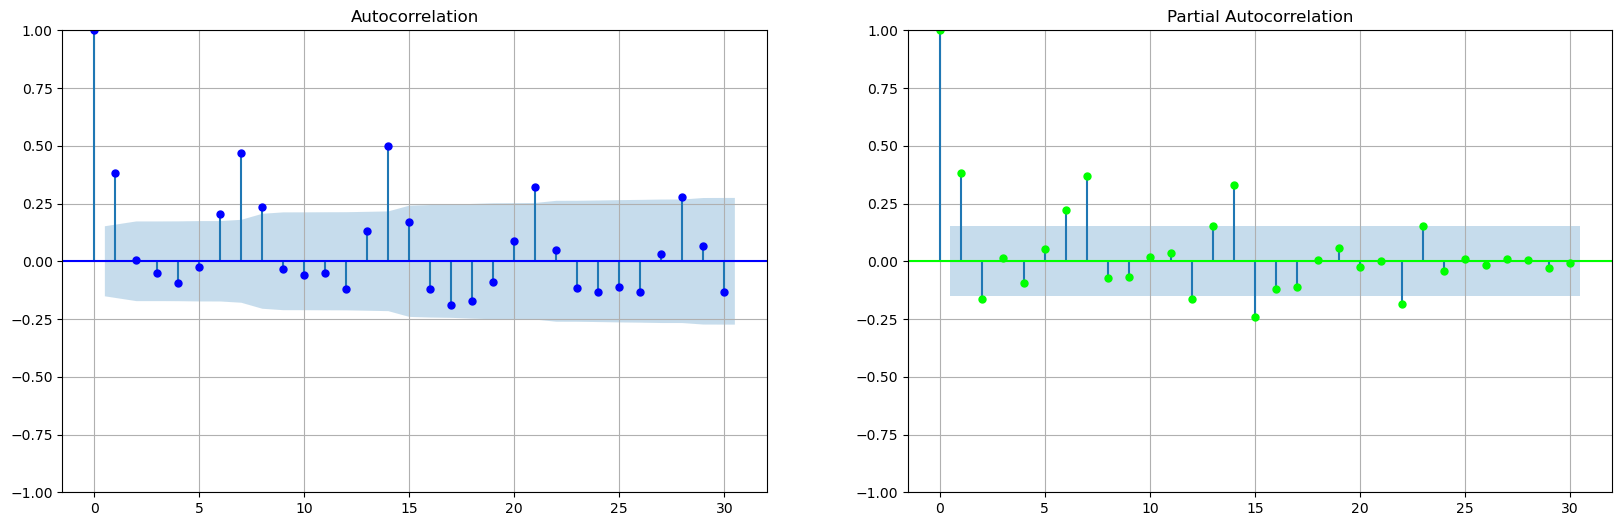

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

plot_acf(daily_counts['count'],  lags=30, ax=axs[0],color="blue")
axs[0].set_title("Autocorrelation")

plot_pacf(daily_counts['count'],  lags=30, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

plt.show()

In [54]:
from wordcloud import WordCloud

def create_cloud_graph(corpus):
    wordcloud = WordCloud(
        width=1600, height=800, max_words=200, background_color='white', collocations=False
    ).generate(' '.join(corpus))
    plt.figure(figsize=(20,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

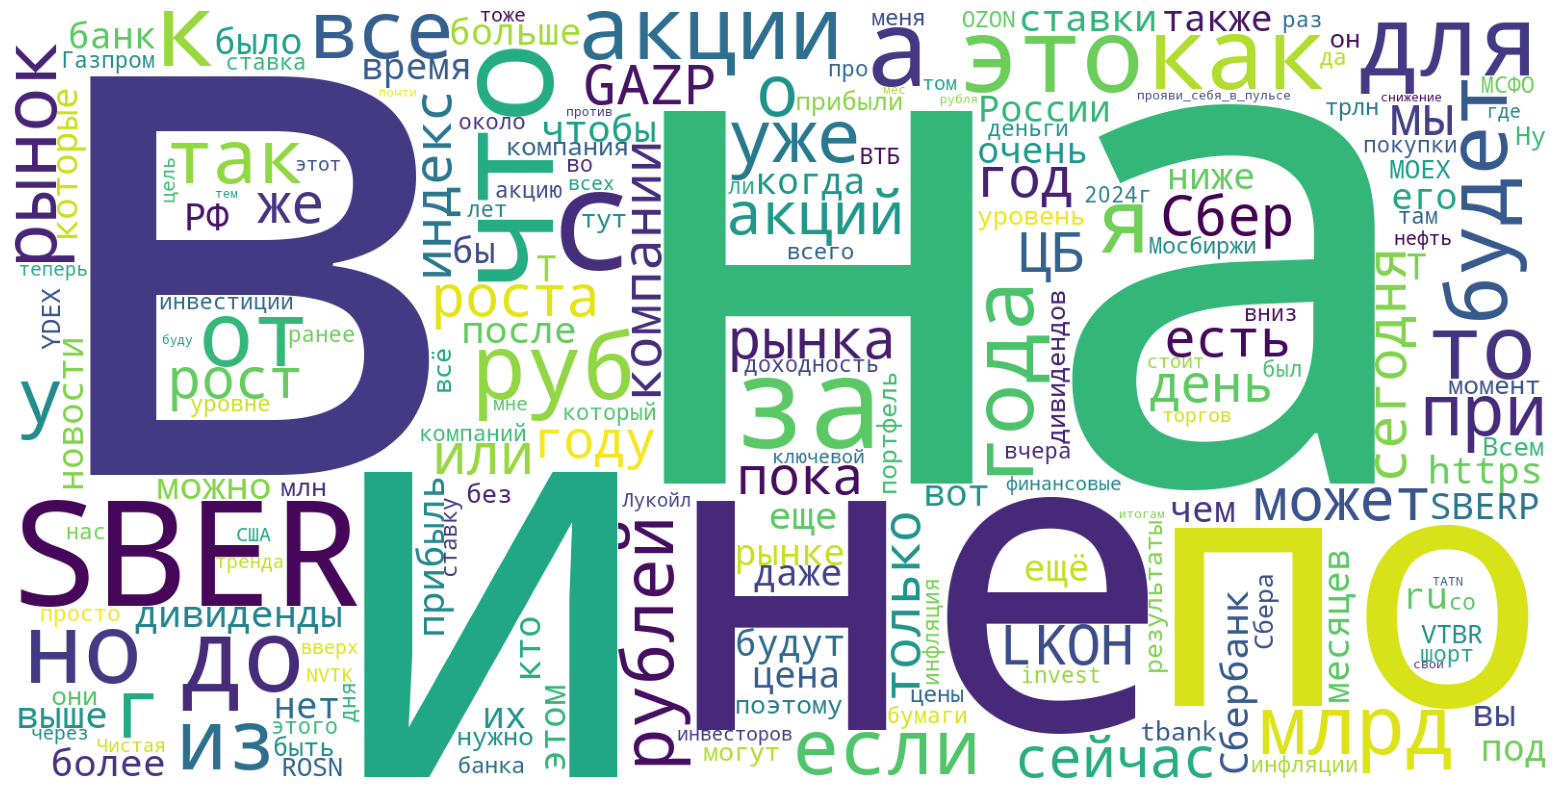

In [55]:
create_cloud_graph(base_df['content'])

In [12]:
import os
import openai

client = openai.OpenAI(
    api_key="eb2f0a9a-a03d-4826-ac5d-719d80b13dc0",
    base_url="https://api.sambanova.ai/v1",
)

In [13]:
response = client.chat.completions.create(
    model='Meta-Llama-3.1-405B-Instruct',
    messages=[{"role":"system","content":"You are a helpful assistant"},{"role":"user","content":"Hello"}],
    temperature =  0.1,
    top_p = 0.1
)

print(response.choices[0].message.content)
      

Hello! It's nice to meet you. Is there something I can help you with, or would you like to chat?


In [16]:
prompt_sber = f"Ты - финансовый аналитик с большим опытом в инвестировании. Твоя задача состоит в анализе сентимента публикаций (оценка тональности текста) из социальной сети Тинькофф Пульс. Верни только одно слово: покупать (если новость положительная), продавать (если негативная), 0 (нейтральный пост, т.е. если явно нельзя определить тональность)"

In [14]:
from tqdm import tqdm
import time

def analyze_sentiment(text):
    try:
        response = client.chat.completions.create(
            model='Meta-Llama-3.1-405B-Instruct',
            messages=[
                {"role": "system", "content": prompt_sber},
                {"role": "user", "content": text}
            ],
            temperature=0.2,
            top_p=0.8
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"Error processing text: {e}")
        return "ERROR"
    

base_df['sentiment'] = None  

In [17]:
# Обработка с прогресс-баром
for idx in tqdm(base_df.head(5).index):
    sentiment = analyze_sentiment(base_df.loc[idx, 'content'])
    base_df.loc[idx, 'sentiment'] = sentiment
    time.sleep(0.5)  # задержка чтобы не перегрузить API

100%|██████████| 5/5 [01:06<00:00, 13.38s/it]


In [18]:
base_df

,id,post_id,inserted,instruments,hashtags,content,reactions_count,comments_count,parse_dt,sentiment
0,1,66810021-0b89-400a-bf7a-d3c155850b07,2025-01-26,"SIBN, MDMG, NLMK, SBER, BSPB, LKOH, ROSN, SNGS...",None,📚 Сегодня пришла долгожданная книга!\n\nДрузья...,1,0,2025-01-26 11:47:22,0
1,2,aeae23c1-cf7e-4c56-ad7d-99b77115de2d,2025-01-26,"GAZP, TATN, MOEX, NMTP, SBER, YDEX, LKOH, ALRS...","пульс_оцени, портфель, прояви_себя_в_пульсе, и...",😉 О чем я пишу: \n\n1.\tВ октябре 2024 года со...,1,0,2025-01-26 11:47:22,покупать
2,3,1ca13924-5339-4e6d-8030-a0810dbecf53,2025-01-26,"ETLN, SBER, YDEX, MVID, X5, LQDT, OZON, CIAN, ...",None,Решил показать полностью свой инвестиционный п...,13,18,2025-01-26 11:47:22,0
3,4,3e0198d8-89f9-4a32-acdf-f66570dddafa,2025-01-26,"NLMK, RTKM, TATN, SBER, ROSN, TRNFP","цитаты, акции, воскресная_рубрика, инвестиции,...",Прочитал «Разумный инвестор» Бенджамина Грэма....,2,2,2025-01-26 11:47:22,покупать
4,5,5e5712ad-8252-467e-9323-793370d36f84,2025-01-26,"HEAD, GAZP, TMOS, MOEX, SBER, YDEX, SMLT, T, L...","крипта, пульс_оцени, инвестиции, пульс_учит, п...","“Богатые становятся еще богаче, а бедные — еще...",6,2,2025-01-26 11:47:22,покупать
...,...,...,...,...,...,...,...,...,...,...
29221,29222,889fe2a0-8931-411e-bec5-b56d03cc7fad,2024-08-13,SBER,None,"{$SBER} Бумага прошла отметку 282, плюс вышла ...",2,2,2025-01-26 12:39:12,None
29222,29223,a8838037-94ce-4b79-ad3c-cd946e159293,2024-08-13,SBER,None,{$SBER} инвесторы стали получать деньги по сде...,2,2,2025-01-26 12:39:12,None
29223,29224,9e8a738c-0a5b-42e1-b385-8761f7db34e3,2024-08-13,SBER,"пульс_оцени, инвестиции, хочу_в_дайджест, проя...","🏦 СБЕР - замедляется, но пока еще идет на реко...",9,3,2025-01-26 12:39:12,None
29224,29225,6da4fcf9-60e2-4c18-a793-909f9d1b031c,2024-08-13,"SGZH, SMLT, MVID, SBER",None,❓Что такое флоатеры и где можно заработать 22%...,12,2,2025-01-26 12:39:12,None


In [20]:
base_df['content'].head().values

array(['📚 Сегодня пришла долгожданная книга!\n\nДрузья, наконец-то я держу в руках книгу, которую так ждал — «Заметки в инвестировании» от Арсагера! 😍 6 Издание\n\nЭто не просто книга, а настоящий клад для всех, кто хочет глубже разобраться в инвестициях. Я давно слышал о ней только положительные отзывы, и теперь не могу дождаться, чтобы окунуться в чтение! 🤓\n\nОбещаю, как только закончу, обязательно поделюсь своими мыслями и сделаю пост с рецензией. 📖💬\n\nА кто уже читал эту книгу? Какие впечатления? Или, может, она тоже в вашем списке на прочтение? Напишите в комментариях, будет интересно обсудить! 👇✨\nМой портфель акций👇\n💥Все подробности у меня в профиле!🔥\n{$SBER} {$POSI} {$SIBN} {$MDMG} {$NLMK} {$LKOH} {$ROSN} {$BSPB} {$MAGN} {$CHMF} {$SNGSP} {$T}',
       '😉 О чем я пишу: \n\n1.\tВ октябре 2024 года создал дивидендный портфель из акций Российских компаний. Каждый месяц пополняю его на 20-30 тысяч рублей и делюсь своими мыслями и результатами. Стараюсь объяснить почему выбрал им

In [56]:
base_df['text_length'] = base_df['content'].str.len()

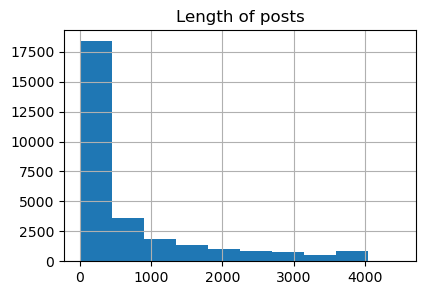

In [59]:
plt.figure(figsize=(10, 3))

plt.subplot(1, 2, 1)
plt.hist(base_df['text_length'], bins=10)
plt.title('Length of posts')

plt.show()

In [9]:
try:
    conn.close()
except:
    pass

In [8]:
# from tpulse import TinkoffPulse

# # Создаем экземпляр
# pulse = TinkoffPulse()

# # Получаем посты для SBER с максимальным курсором
# posts_from_ticker = pulse.get_posts_by_ticker(ticker="SBER", cursor=999999999)

# Берем первый пост из списка
first_post = posts_from_ticker["items"][5]

# Смотрим структуру данных
print("Ключи верхнего уровня:")
print(first_post.keys())

print("\nСтруктура content:")
print(first_post["content"].keys())

print("\nПолные данные поста:")
import json
print(json.dumps(first_post, indent=2, ensure_ascii=False))

# Если нужно посмотреть все посты
print("\nВсего постов в выборке:", len(posts_from_ticker["items"]))

Ключи верхнего уровня:
dict_keys(['id', 'commentsCount', 'inserted', 'isEditable', 'serviceTags', 'owner', 'reactions', 'content', 'baseTariffCategory', 'isBookmarked', 'status'])

Структура content:
dict_keys(['type', 'text', 'instruments', 'hashtags', 'profiles', 'images', 'strategies'])

Полные данные поста:
{
  "id": "277d7bf8-e8e6-48f7-a800-a779212de5e9",
  "commentsCount": 11,
  "inserted": "2025-01-25T15:32:48.784Z",
  "isEditable": false,
  "serviceTags": [],
  "owner": {
    "id": "85bd0e1d-1f36-4694-9aa1-60fac20f9f55",
    "nickname": "Annet211",
    "image": "7ec3a776-5d5d-472b-b1ae-d55e99c57e29",
    "donationActive": false,
    "block": false,
    "serviceTags": [
      {
        "id": "profile"
      }
    ]
  },
  "reactions": {
    "totalCount": 18,
    "counters": [
      {
        "type": "like",
        "count": 18
      }
    ]
  },
  "content": {
    "type": "simple",
    "text": "Ну это уже полнейшая жесть 🤯\nЕжемесячный ипотечный платёж на новостройки в российски